## Example script: training and predicting with ConvLSTM
Author          : SSI project team Wadden Sea <br>
First Built     : 2021.08.01 <br>
Last Update     : 2021.08.12 <br>
Description     : This notebook serves as an example of training and predicting with
                  Convolutional Long-Short Term Memeory Neural Network (ConvLSTM). <br>
Dependency      : os, numpy, pytorch <br>
Return Values   : time series / array <br>
Caveat!         : This module performs many-to-one prediction! It supports CUDA. <br>


In [3]:
import os
import sys
import numpy as np
import torch
import torch.nn.functional
from torch.autograd import Variable
import matplotlib.pyplot as plt

# import convlstm
sys.path.append("../../../src")
import convlstm

In [4]:
# import random
# random.seed(0)
# np.random.seed(0)
# torch.manual_seed(0)

### Path

In [5]:
# please specify output path for the model
output_path = './model'
if not os.path.exists(output_path):
   os.makedirs(output_path, exist_ok = True)

### Hyper-parameter of neural network

In [6]:
input_channels = 4 # number of input channels e.g. concentration heatmap, current, wind curl, etc.
output_channels = 2
hidden_channels = [6, 3, output_channels] # the last digit is the output channel of each ConvLSTMCell (so we are using 3 layers)
kernel_size = 3
batch_size = 1 #not used in this tutorial
learning_rate = 0.01
num_epochs = 201 #51

### Hardware info and version of pytorch

In [7]:
print ("Pytorch version {}".format(torch.__version__))
# check if CUDA is available
use_cuda = torch.cuda.is_available()
# use GPU if possible
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device to be used for computation: {}".format(device))

Pytorch version 1.8.1
Device to be used for computation: cpu


### Initialize model

In [8]:
# initialize our model
model = convlstm.ConvLSTM(input_channels, hidden_channels, kernel_size).to(device)
# choose loss function
loss_fn = torch.nn.MSELoss()
# choose optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
# check the model / loss function and optimizer
print(model)
print(loss_fn)
print(optimizer)

ConvLSTM(
  (cell0): ConvLSTMCell(
    (Wxi): Conv2d(4, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (Whi): Conv2d(6, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (Wxf): Conv2d(4, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (Whf): Conv2d(6, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (Wxc): Conv2d(4, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (Whc): Conv2d(6, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (Wxo): Conv2d(4, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (Who): Conv2d(6, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  )
  (cell1): ConvLSTMCell(
    (Wxi): Conv2d(6, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (Whi): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (Wxf): Conv2d(6, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (Whf): Conv2d(3, 3, kernel_size=(3, 3), stride=

### Create dummy data for testing

In [9]:
# training data
nx=5; ny=7; nt=3
train_x_torch = Variable(torch.randn(nt, input_channels, ny, nx)).to(device) # shape [timestep, channel, ny, nx]
train_y_torch = Variable(torch.randn(nt, output_channels, ny, nx)).float().to(device)
#
# testing data
#test_x_torch = Variable(torch.randn(2, input_channels, ny, nx)).to(device) # shape [timestep, channel, ny, nx]
#test_y_torch = Variable(torch.randn(2, output_channels, ny, nx)).float().to(device)
# get length of training set
train_steps, input_channels, ny, nx = train_x_torch.shape

### Training

In [19]:
loss = np.zeros(num_epochs) # save for every epoch the sum of loss for all the time steps
pred_y=[]
mape = np.zeros(num_epochs) #save for every epoch the sum of the mean absolute percentage error
for epoch in range(num_epochs):
    # Clear stored gradient
    model.zero_grad()
    # loop through all timesteps
    for t in range(train_steps):
        #
        #torch.autograd.Variable = to the original tensor, so it is unnecessary
        #var_x = torch.autograd.Variable(train_x_torch[t,:,:,:].view(-1,input_channels,ny,nx)).to(device) # record gradient
        #var_y = torch.autograd.Variable(train_y_torch[t,:,:,:].view(-1,output_channels,ny,nx)).to(device) # record gradient
        #
        #train_x_torch[t,:,:,:].view(-1,input_channels,ny,nx) = train_x_torch[t,:,:,:][np.newaxis,...]
        #train_x_torch[t,:,:,:].view(-1,input_channels,ny,nx).shape = (1,input_channels,ny,nx)
        #train_y_torch[t,:,:,:].view(-1,output_channels,ny,nx).shape = (1,output_channels,ny,nx)
        var_x = train_x_torch[t,:,:,:].view(-1,input_channels,ny,nx).to(device) #(1,input_channels,ny,nx)
        var_y = train_y_torch[t,:,:,:].view(-1,output_channels,ny,nx).to(device) # (1,output_channels,ny,nx)
        #
        # Forward process
        pred_y0, _ = model(var_x, t) #var_x=(1,input_channels,ny,nx)  pred_y=(1,output_channels,ny,nx)
        # compute loss (and the cumulative loss from all the time steps)
        if t == 0:
            loss0 = loss_fn(pred_y0, var_y) #var_y=(1,output_channels,ny,nx)
            mape0=np.mean( abs((pred_y0-var_y)/var_y).detach().numpy() )
        else:
            loss0 += loss_fn(pred_y0, var_y)
            mape0 += np.mean( abs((pred_y0-var_y)/var_y).detach().numpy() )
        #print the loss for each time step that we are trying to predict
        #if epoch % 10 == 0: print("Epoch=", epoch, "time=", t, "MSE=", loss_fn(pred_y, var_y).item())
        #print("Epoch=", epoch, "time=", t, "MSE=", loss_fn(pred_y0, var_y).item())
        if epoch == num_epochs-1: pred_y.append(pred_y0.detach().numpy())
    #cumulative loss from all the time steps (the loss we use for bacward propagation)
    if epoch % 10 == 0: 
        print("Epoch ", epoch, "; sum(MSE(t)) = ", loss0.item(), "; sum(MAE(t)) = ", mape0) 
    #if epoch % 10 == 0: print("sum MSE(t) = ", loss0.item()) 
    #print("sum MSE(t) = ", loss0.item()) 
    loss[epoch] = loss0.item() #tensor value to standard float
    mape[epoch] = mape0 

    # Zero out gradient, else they will accumulate between epochs
    optimizer.zero_grad()
    
    # Backward pass
    # Backward propagation is kicked off when we call .backward() on the error tensor.
    # Autograd then calculates and stores the gradients for each model parameter in the parameter’s ".grad" attribute.
    loss0.backward()

    # Update parameters
    optimizer.step() #to initiate gradient descent

# save the general checkpoint
torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss0.item()
            }, os.path.join(output_path,'Lagrangian_ML_training_checkpoint.pt'))
print("The checkpoint of the model and training status is saved.")
#
pred_y=np.reshape(pred_y,(nt,output_channels,ny,nx)) #save to numpy array outputs (nt,output_channels,ny,nx)

Epoch  0 ; sum(MSE(t)) =  0.9352471828460693 ; sum(MAE(t)) =  27.36209
Epoch  10 ; sum(MSE(t)) =  0.8884185552597046 ; sum(MAE(t)) =  44.32109
Epoch  20 ; sum(MSE(t)) =  0.885991096496582 ; sum(MAE(t)) =  45.468937
Epoch  30 ; sum(MSE(t)) =  0.8751469254493713 ; sum(MAE(t)) =  46.15951
Epoch  40 ; sum(MSE(t)) =  0.8549214601516724 ; sum(MAE(t)) =  43.145016
Epoch  50 ; sum(MSE(t)) =  0.8437141180038452 ; sum(MAE(t)) =  29.65254
Epoch  60 ; sum(MSE(t)) =  0.8412585258483887 ; sum(MAE(t)) =  47.380554
Epoch  70 ; sum(MSE(t)) =  0.844801664352417 ; sum(MAE(t)) =  50.85138
Epoch  80 ; sum(MSE(t)) =  0.8304698467254639 ; sum(MAE(t)) =  42.06608
Epoch  90 ; sum(MSE(t)) =  0.8349236845970154 ; sum(MAE(t)) =  32.353836
Epoch  100 ; sum(MSE(t)) =  0.8329381942749023 ; sum(MAE(t)) =  27.85095
Epoch  110 ; sum(MSE(t)) =  0.8138623833656311 ; sum(MAE(t)) =  30.779749
Epoch  120 ; sum(MSE(t)) =  0.8186662197113037 ; sum(MAE(t)) =  31.696531
Epoch  130 ; sum(MSE(t)) =  0.8083949089050293 ; sum(MAE(t

Text(0, 0.5, '$\\sum_t$ loss[epoch,t] / N')

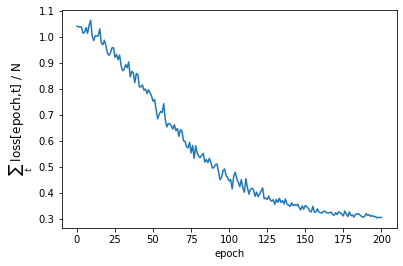

In [11]:
plt.plot(range(num_epochs),loss/nt)
plt.xlabel('epoch');plt.ylabel('$\sum_t$ loss[epoch,t] / N',fontsize=12)

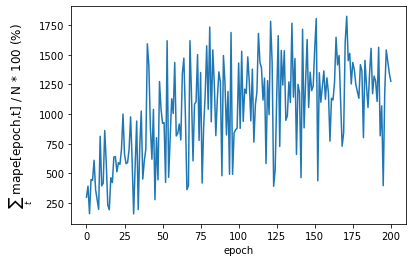

In [12]:
plt.plot(range(num_epochs),mape/nt*100)
plt.xlabel('epoch');plt.ylabel('$\sum_t$ mape[epoch,t] / N * 100 (%)',fontsize=12);

In [20]:
loss[-1]/nt,mape[-1]/nt*100

(0.2608041763305664, 1071.209971110026)

In [21]:
#check the errors for each time of the last epoch
msee=[];mapee=[]
for i in range(nt):
    mse0=np.mean( (pred_y-train_y_torch.numpy())[i,...]**2)
    mape0=np.mean( abs(((pred_y-train_y_torch.numpy())/train_y_torch.numpy())[i,...]) )
    msee.append(mse0); mapee.append(mape0)
    print(f"t={i}: mse={mse0};  mape={mape0}%")
print("mean(mse(t))=",np.sum(msee)/nt)
print("mean(mape(t))=",np.sum(mapee)/nt*100,"%")
print()
print("MAE using the final output matrix = ",abs((pred_y-train_y_torch.numpy())/train_y_torch.numpy()).mean()*100,"%")

t=0: mse=0.3024400472640991;  mape=31.223196029663086%
t=1: mse=0.20130576193332672;  mape=0.5228323340415955%
t=2: mse=0.2786666452884674;  mape=0.3902694284915924%
mean(mse(t))= 0.26080413659413654
mean(mape(t))= 1071.209971110026 %

MAE using the final output matrix =  1071.2100982666016 %


In [30]:
#understand better above

In [31]:
#so the function "Variable" and "torch.autograd.Variable" seem to be useless because = to the original torch tensor
a=torch.from_numpy(np.arange(10)) #convert numpy to torch tensor
print(Variable(torch.arange(10)),torch.arange(10),a,torch.autograd.Variable(a))
print()

epoch=0
model.zero_grad()
for t in range(2):
    #torch.autograd.Variable(train_x_torch[t,:,:,:].view(-1,input_channels,ny,nx)).to(device) = below
    #so torch.autograd.Variable seems useless
    var_x = train_x_torch[t,:,:,:].view(-1,input_channels,ny,nx).to(device) 
    var_y = train_y_torch[t,:,:,:].view(-1,output_channels,ny,nx).to(device)
    pred_y, _ = model(var_x, t)
    print(var_x.shape,var_y.shape,pred_y.shape,var_y.sum(),pred_y.sum())
    if t == 0:
        loss0 = loss_fn(pred_y, var_y)
    else:
        loss0 += loss_fn(pred_y, var_y)
    print(loss0)
optimizer.zero_grad()
loss0.backward()
optimizer.step()
#
a=train_y_torch[t,...][np.newaxis,...].to(device) 
(a-var_y).sum()

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]) tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]) tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]) tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

torch.Size([1, 4, 7, 5]) torch.Size([1, 2, 7, 5]) torch.Size([1, 2, 7, 5]) tensor(1.2755) tensor(3.1022, grad_fn=<SumBackward0>)
tensor(0.3727, grad_fn=<MseLossBackward>)
torch.Size([1, 4, 7, 5]) torch.Size([1, 2, 7, 5]) torch.Size([1, 2, 7, 5]) tensor(5.0983) tensor(0.5063, grad_fn=<SumBackward0>)
tensor(0.6555, grad_fn=<AddBackward0>)


tensor(0.)

In [ ]:
#below method not working well , but it is very similar to Yang model

In [20]:
#https://github.com/automan000/Convolutional_LSTM_PyTorch/blob/master/convolution_lstm.py

import torch
import torch.nn as nn
from torch.autograd import Variable


class ConvLSTMCell(nn.Module):
    def __init__(self, input_channels, hidden_channels, kernel_size):
        super(ConvLSTMCell, self).__init__()

        #assert hidden_channels % 2 == 0

        self.input_channels = input_channels
        self.hidden_channels = hidden_channels
        self.kernel_size = kernel_size
        self.num_features = 4

        self.padding = int((kernel_size - 1) / 2)

        self.Wxi = nn.Conv2d(self.input_channels, self.hidden_channels, self.kernel_size, 1, self.padding, bias=True)
        self.Whi = nn.Conv2d(self.hidden_channels, self.hidden_channels, self.kernel_size, 1, self.padding, bias=False)
        self.Wxf = nn.Conv2d(self.input_channels, self.hidden_channels, self.kernel_size, 1, self.padding, bias=True)
        self.Whf = nn.Conv2d(self.hidden_channels, self.hidden_channels, self.kernel_size, 1, self.padding, bias=False)
        self.Wxc = nn.Conv2d(self.input_channels, self.hidden_channels, self.kernel_size, 1, self.padding, bias=True)
        self.Whc = nn.Conv2d(self.hidden_channels, self.hidden_channels, self.kernel_size, 1, self.padding, bias=False)
        self.Wxo = nn.Conv2d(self.input_channels, self.hidden_channels, self.kernel_size, 1, self.padding, bias=True)
        self.Who = nn.Conv2d(self.hidden_channels, self.hidden_channels, self.kernel_size, 1, self.padding, bias=False)

        self.Wci = None
        self.Wcf = None
        self.Wco = None

    def forward(self, x, h, c):
        ci = torch.sigmoid(self.Wxi(x) + self.Whi(h) + c * self.Wci)
        cf = torch.sigmoid(self.Wxf(x) + self.Whf(h) + c * self.Wcf)
        cc = cf * c + ci * torch.tanh(self.Wxc(x) + self.Whc(h))
        co = torch.sigmoid(self.Wxo(x) + self.Who(h) + cc * self.Wco)
        ch = co * torch.tanh(cc)
        return ch, cc

    def init_hidden(self, batch_size, hidden, shape):
        if self.Wci is None:
            self.Wci = nn.Parameter(torch.zeros(1, hidden, shape[0], shape[1])).cpu()
            self.Wcf = nn.Parameter(torch.zeros(1, hidden, shape[0], shape[1])).cpu()
            self.Wco = nn.Parameter(torch.zeros(1, hidden, shape[0], shape[1])).cpu()
        else:
            assert shape[0] == self.Wci.size()[2], 'Input Height Mismatched!'
            assert shape[1] == self.Wci.size()[3], 'Input Width Mismatched!'
        return (Variable(torch.zeros(batch_size, hidden, shape[0], shape[1])).cpu(),
                Variable(torch.zeros(batch_size, hidden, shape[0], shape[1])).cpu())


class ConvLSTM(nn.Module):
    # input_channels corresponds to the first input feature map
    # hidden state is a list of succeeding lstm layers.
    def __init__(self, input_channels, hidden_channels, kernel_size, step=1, effective_step=[1]):
        super(ConvLSTM, self).__init__()
        self.input_channels = [input_channels] + hidden_channels
        self.hidden_channels = hidden_channels
        self.kernel_size = kernel_size
        self.num_layers = len(hidden_channels)
        self.step = step
        self.effective_step = effective_step
        self._all_layers = []
        for i in range(self.num_layers):
            name = 'cell{}'.format(i)
            cell = ConvLSTMCell(self.input_channels[i], self.hidden_channels[i], self.kernel_size)
            setattr(self, name, cell)
            self._all_layers.append(cell)

    def forward(self, input):
        internal_state = []
        outputs = []
        for step in range(self.step):
            x = input
            for i in range(self.num_layers):
                # all cells are initialized in the first step
                name = 'cell{}'.format(i)
                if step == 0:
                    bsize, _, height, width = x.size()
                    (h, c) = getattr(self, name).init_hidden(batch_size=bsize, hidden=self.hidden_channels[i],
                                                             shape=(height, width))
                    internal_state.append((h, c))

                # do forward
                (h, c) = internal_state[i]
                x, new_c = getattr(self, name)(x, h, c)
                internal_state[i] = (x, new_c)
                #print(step,name,input.shape,x.shape)
            # only record effective steps
            if step in self.effective_step:
                #print(step,name,input.shape,x.shape)
                outputs.append(x)
        return outputs, (x, new_c)


if __name__ == '__main__':
    
    # gradient check
    #convlstm = ConvLSTM(input_channels=6, hidden_channels=[8, 4, 2], kernel_size=3, step=7,
    #                    effective_step=[6]).cpu()
    for i in range(num_epochs):
        convlstm = ConvLSTM(input_channels=input_channels, hidden_channels=hidden_channels, kernel_size=kernel_size, step=nt,
                            effective_step=[nt-1]).cpu()
        loss_fn = torch.nn.MSELoss()

        #input = Variable(torch.randn(3, 6, 10, 12)).cpu()
        #target = Variable(torch.randn(3, 2,10, 12)).double().cpu()
        input=train_x_torch
        target=train_y_torch.double()

        output = convlstm(input)
        output = output[0][0].double()
        res = torch.autograd.gradcheck(loss_fn, (output, target), eps=1e-6, raise_exception=True)
        #print()
        #print(res)

    print(input.shape,output.shape)

torch.Size([3, 4, 7, 5]) torch.Size([3, 2, 7, 5])


In [22]:
#contrast above 2 methods

a=[];b=[]
for i in range(nt):
    a.append(np.mean( (pred_y-train_y_torch.numpy())[i,...]**2))
    b.append( float(((output-target)[i,...]**2).mean().detach().numpy()))
print(a,np.sum(a))
print(b,np.sum(b))
print()
abs((output-target)/target).mean()*100, abs((pred_y-train_y_torch.numpy())/train_y_torch.numpy()).mean()*100

[1.108068, 0.7323234, 0.6472054] 2.4875968
[1.039829985680998, 1.0002542244964725, 1.08927732847695] 3.12936153865442



(tensor(102.6513, dtype=torch.float64, grad_fn=<MulBackward0>),
 143.71206760406494)